In [5]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

import dask
import xarray as xr
from dask.diagnostics import ProgressBar


In [6]:
!which python

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python


In [7]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


In [8]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [9]:
static = xr.open_dataset('../data/usa/era5_slt_z_slor_lsm_stationary_field.nc')

In [10]:
era5 = xr.open_dataset('../data/usa/era5_lsp_cp_1981-2017_daysum.nc')
era5 = shift_time(era5, -dt.timedelta(hours=23))

In [11]:
glofas = xr.open_dataset('../data/usa/glofas_reanalysis_usa_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
# da.transpose(dims='latitude')  # flip?

In [12]:
glofas = glofas.isel(time=slice(0, 365*20))  # just to reduce the amount of data

### basic spatial subset - compute the model only in this domain

In [13]:
box_model = dict(latitude=slice(40, 28), 
                 longitude=slice(-95, -85))

In [14]:
glofas = glofas.sel(box_model)
era5 = era5.sel(box_model)

In [15]:
dis = glofas['dis']

In [16]:
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
z_glofas = z_glofas.drop('time')  # time is misleading as the topography does not change

In [17]:
tp = (era5['cp']+era5['lsp'])*1000
tp.name = 'total precip [mm]'
tp = tp.interp(latitude=glofas.latitude,
               longitude=glofas.longitude)

MemoryError: 

# Preprocessing routines - Summary

In [13]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [14]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
    b = da_timeseries - da_timeseries.mean('time')
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
    out = b.dot(a)/a.std('time')/b.std()/N
    out.name = 'correlation coefficient'
    return out

In [15]:
def select_river(dis):
    river = dis.min('time') > 5
    river.name = 'river mask [0/1]'
    return river

In [16]:
def select_upstream_river(dis_box, dis_point, z_box, z_point, rivermask, pct):
    lags = [-1, 1]

    timelag_corrs = np.full((len(lags), len(dis_box.latitude), len(dis_box.longitude)), np.nan)
    for t, lag in enumerate(lags):
        if lag > 0:  # dis_box with data from previous timesteps
            cntr = dis_point[lag:]
            dis_box_shift = dis_box[:-lag]
        elif lag < 0:  # dis_box with data from future timesteps
            cntr = dis_point[:lag]
            dis_box_shift = dis_box[-lag:]

        dis_box_relevant = dis_box_shift.where(rivermask==1)
        timelag_corrs[t,:,:] = correlate(dis_box_relevant, cntr, timelag=True)

    lag_influencing = timelag_corrs[1,:,:]>timelag_corrs[0,:,:]
    #plt.imshow(lag_influencing)

    influencer = (dis_box.mean('time') > pct*dis_point.mean('time'))  \
                  &(z_box > z_point)   \
                  &(rivermask==1) & lag_influencing
    influencer.name = 'gridpoints influencing discharge [0/1]'
    #influencer.plot()
    return influencer

In [17]:
shifts = range(1,4)
X_dis = add_shifted_predictors(glofas, shifts, variables='all')
X_dis = X_dis.drop('dis')  # we actually want to predict (t) with (t-1, t-2, t-3)
y_dis = glofas['dis']

In [18]:
i, j = 70, 38
di = 20
dj = 20
pct = 0.1  # influencing gridpoint must have mean discharge more than this percentage

i0, i1 = i-di, i+di
j0, j1 = j-dj, j+dj

In [19]:
tp_box = tp[:, i0:i1, j0:j1]
noprecip = tp_box.mean(['longitude', 'latitude']) < 0.1
print('percentage:',sum(noprecip.astype(int))/noprecip.size) # .plot() #.plot() #'#'
print(noprecip)

percentage: <xarray.DataArray 'total precip [mm]' ()>
array(0.334986)
<xarray.DataArray 'total precip [mm]' (time: 13514)>
array([ True,  True,  True, ...,  True, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31


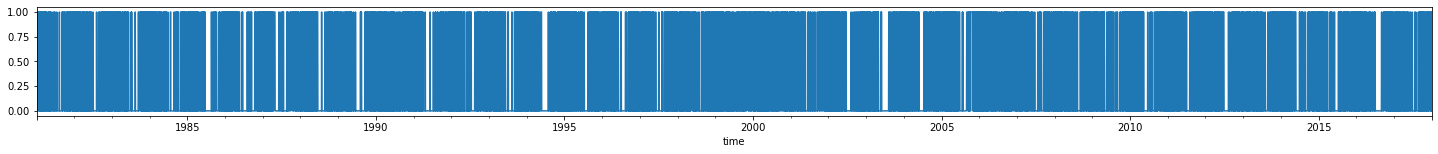

In [20]:
fig, ax = plt.subplots(figsize=(25,2))
noprecip.astype(int).to_pandas().plot(ax=ax)

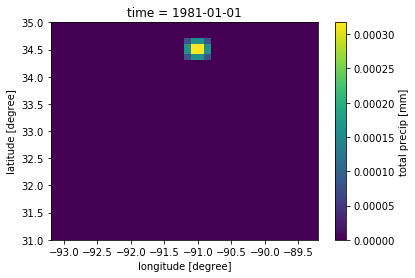

In [21]:
tp_box.where(noprecip).isel(time=0).plot()

### pre-selection of upstream river gridpoints

In [22]:
dis_point = dis[:,i,j]
dis_box = dis[:, i0:i1, j0:j1]
z_point = z_glofas[i,j]
z_box = z_glofas[i0:i1,j0:j1]


rivermask = select_river(dis_box)

### from the river points, select the upstream ones

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<xarray.DataArray 'gridpoints influencing discharge [0/1]' ()>
array(26)


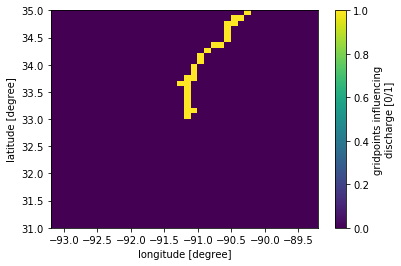

In [23]:
# version A
upstream = select_upstream_river(dis_box, dis_point, z_box, z_point, rivermask, pct)

upstream.plot()
print(upstream.sum())

In [24]:
# version B
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
# maybe not l


markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

NameError: name 'image' is not defined

## tutorial

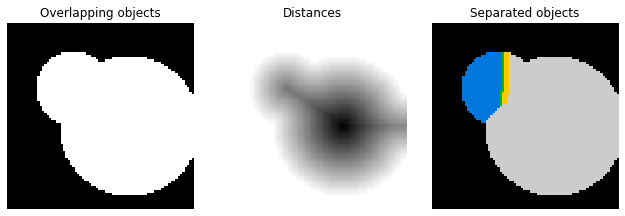

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 30
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [28]:
local_maxi

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [29]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [30]:
labels.max()

4